In [1]:
import pandas as pd
import seaborn as sns
from  matplotlib import pyplot as plt, ticker, patches
import numpy as np
from scipy.interpolate import Rbf
from datetime import date, timedelta, datetime

In [2]:
# For high pixel-density screens, e.g. retina, only
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Make figures bigger
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7
sns.set(style="darkgrid")

In [3]:
url = "https://covid.ourworldindata.org/data/ecdc/full_data.csv"
data = pd.read_csv(url).set_index(["location", "date"]).sort_index()
data.loc["United Kingdom"]

,new_cases,new_deaths,total_cases,total_deaths
date,,,,
2019-12-31,0,0,0,0
2020-01-01,0,0,0,0
2020-01-02,0,0,0,0
2020-01-03,0,0,0,0
2020-01-04,0,0,0,0
...,...,...,...,...
2020-04-03,4244,389,33718,2921
2020-04-04,4450,684,38168,3605
2020-04-05,3735,708,41903,4313


In [4]:
# United States individual states
# Source: https://covidtracking.com/api/states.csv

In [5]:
# TODO
# v Gather data for country's testing methodoligies
# v Insert horizontal bars marking the testing methodology
# v Move horizontal bars to the top
# v Get statistics on case timeline (below)
# v Have policy changes be different saturations of blue
# v Create side-plots with daily cases and death rate with same bars but without text
# - have death rate shown on same plot
# v Show dotted line when we expect the effect of a policy change to start showing


# Timeline:
# * Incubation Period:
#   - Infected to symptoms: 5.1 days -- https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported
# * Hospitalisation: 
#   - symptoms to hospitalisation: 7 days in China -- https://els-jbs-prod-cdn.literatumonline.com/pb/assets/raw/Lancet/infographics/coronavirus/Coronavirus_MedianTimeline_Infographic-1584612208650.jpg
#   - infected to hospitalisation: 12 days in China -- https://jamanetwork.com/journals/jama/fullarticle/2762130
# * Death
#   - symptoms to death: 14 days median in China -- https://pubmed.ncbi.nlm.nih.gov/31994742/
#   - symptoms to death: 8 days median in Italy -- https://www.epicentro.iss.it/coronavirus/bollettino/Report-COVID-2019_17_marzo-v2.pdf 

In [6]:
def plot_timeline(title, df, metadata, start_date, ax, allow_minus = False, show_text = True, x_scale = 1.0, y_scale = 1.0, line_color = None, event_delay = None, total_tests_df = None):
    y = df.to_numpy()
    x = np.linspace(0, len(df)-1, len(df))
    rbf = Rbf(x, y)
    x_interpolate = np.linspace(0, len(df) -1, len(df) * 10)
    y_interpolate = rbf(x_interpolate)
    y_interpolate[y_interpolate < 0] = y_interpolate[y_interpolate < 0] if allow_minus else y_interpolate[y_interpolate < 0]
    line_color = line_color if line_color else sns.color_palette()[0]
     
    event_colors = {
        "case": "tab:orange",
        "death": "tab:red",
        "policy": "tab:blue"
    }
    
    phase_colors = [(0.83, 0.87, 0.95),(0.78, 0.83, 0.90),(0.65, 0.75, 0.85)]
    
    plot_ceil = max(y)*(y_scale + 0.7)+((max(y)-min(y))*0.1)
    plot_floor = min(y)-((max(y)-min(y))*0.1) if allow_minus else max(y)*-(0.012/y_scale)
    data_start_date = pd.to_datetime(df.index[0]).date()
    data_end_date = pd.to_datetime(df.index[-1]).date()
    delay_past_data_end_date = event_delay - (data_end_date - metadata['events'][-1]['date']).days + 1 if event_delay else 0
    end_date = data_end_date + timedelta(days=1) if (event_delay is None or delay_past_data_end_date <= 0) else data_end_date + timedelta(delay_past_data_end_date)
    plot_start = (start_date - data_start_date).days
    plot_end = plot_start + (end_date - start_date).days
    plot_width = plot_end - plot_start
    phases_y_delta = 0 if len(metadata['phases']) == 0 else 0.07

    # Set plot width and height
    plt.ylim(plot_floor, plot_ceil)
    plt.xlim(plot_start, plot_end)
    
    # Get the current reference
    ax.set_ylim(plot_floor, plot_ceil)
    ax.set_xlim(plot_start, plot_end)
    
    # Plot rectangle to align bottom of plot with y=0
    if not allow_minus:
        rect = patches.Rectangle((plot_start, 0), plot_width, plot_floor, edgecolor='white', facecolor='white', zorder=0.8)
        ax.add_patch(rect)
    
    # Plot vertical line per day
    for day in range(plot_start, plot_end):
        ax.axvline(day, 0, 1, linestyle='-', color='ghostwhite', alpha=0.4, zorder=0.1, linewidth=plot_width*0.03)
    
    # Plot phases
    for i, phase in enumerate(metadata['phases']):
        start = phase['from'] if (phase['from'] > start_date) else start_date
        end = phase['to'] if (phase['to'] < end_date) else end_date + timedelta(days=1)
        start_x = (start - start_date).days + plot_start
        start_y = -plot_ceil*0.02
        width = (end - start_date).days + plot_start - start_x
        color = phase_colors[len(phase_colors)-len(metadata['phases'])+i]
        rect = patches.Rectangle((start_x, plot_ceil), width, (-plot_ceil*0.05) / y_scale, edgecolor=color, facecolor=color, zorder=0.8)
        ax.add_patch(rect)
        label = "{}".format(phase['type'].title())
        if show_text:
            ax.text(start_x + width/2.0, plot_ceil*0.987, label, verticalalignment='top', horizontalalignment='center')
    
    # Plot events
    event_palette = sns.color_palette("husl", len(metadata['events'])+1)
    for i, event in enumerate(metadata['events']):
        alpha = 0.8
        event_color = event_palette[i+1]
        days = (event['date'] - start_date).days + plot_start
        ax.axvline(days, 0, 1, color=event_color, alpha=alpha, zorder=0.7)
        if event_delay:
            ax.axvline(days + event_delay, 0, 1, linestyle=':', color=event_color, alpha=alpha, zorder=0.7)
            ax.arrow(days + plot_width*0.01, plot_ceil*(0.5 - i*0.1), event_delay - plot_width*0.02, 0, zorder=0.6, head_width=plot_ceil*0.015/y_scale, head_length=event_delay*0.05, ec=event_color, fc=event_color, alpha=alpha, width=plot_ceil*0.0005, length_includes_head=True)
            #if show_text:
            #    impact_label = "start of impact".format(i+1)
            #    ax.text(days + event_delay - (plot_width*0.02) / x_scale, plot_ceil*0.92, impact_label, rotation=90, verticalalignment='top')
        if show_text:
            label = "{}".format(event['label'])
            if event.get("position","over") == "over":
                ax.text(days - (plot_width*0.017) / x_scale, plot_ceil*(0.99 - phases_y_delta), label, rotation=90, verticalalignment='top')
            else:
                ax.text(days + (plot_width*0.007) / x_scale, plot_ceil*(0.99 - phases_y_delta), label, rotation=90, verticalalignment='top')
    
    # Plot extrapolated curve
    sns.lineplot(y=y_interpolate, x=x_interpolate, ax=ax, legend=False, color=line_color)
    
    # Plot discs for actual data points
    sns.scatterplot(data=pd.DataFrame(y, x), ax=ax, legend=False, palette=[line_color])
    
    # Plot number of tests
    if total_tests_df is not None:
        tests_df = total_tests_df.diff().dropna()
        tests_start_date = pd.to_datetime(tests_df.index[0]).date()
        tests_offset = (data_start_date - tests_start_date).days
        tests_y = tests_df.to_numpy()
        tests_x = np.linspace(0 - tests_offset, len(tests_df) - 1 - tests_offset, len(tests_df))
        tests_rbf = Rbf(tests_x, tests_y)
        tests_x_interpolate = np.linspace(0 - tests_offset, len(tests_df) -1 - tests_offset, len(tests_df) * 10)
        tests_y_interpolate = tests_rbf(tests_x_interpolate)
        tests_y_interpolate[tests_y_interpolate < 0] = tests_y_interpolate[tests_y_interpolate < 0] if allow_minus else tests_y_interpolate[tests_y_interpolate < 0]
        tests_line_color = sns.color_palette()[5]
        sns.lineplot(y=tests_y_interpolate, x=tests_x_interpolate, ax=ax, legend=False, color=tests_line_color)
        sns.scatterplot(data=pd.DataFrame(tests_y, tests_x), ax=ax, legend=False, palette=[tests_line_color])
    
    # Make x-axis have dates
    fmt_date = ticker.FuncFormatter(lambda x, pos: '' if x % 1 != 0 else (data_start_date + timedelta(days=int(x))).strftime("%b %-d"))
    fmt_plus = ticker.FuncFormatter(lambda x, pos: "+{}".format(x) if x > 0 else x)
    ax.xaxis.set_major_formatter(fmt_date)
    if allow_minus:
        ax.yaxis.set_major_formatter(fmt_plus)

    
    # Set title and labels
    plt.title("{} {}".format(metadata['country_code'], title.title()))
    if show_text:
        ax.set_ylabel("{}".format(title.title()))
        
    # Draw Legend
    legend_items = {
        "Policy Event": ax.axvline(-10, -10, 1, linestyle='-', color='slategray'),
        "Start of Effect": ax.axvline(-10, -10, 1, linestyle=':', color='slategray'),
        title: ax.axvline(-10, -10, 1, linestyle='-', color=line_color)
    }
    if total_tests_df is not None:
        legend_items = {
            **legend_items,
            "Daily Tests": ax.axvline(-10, -10, 1, linestyle='-', color=tests_line_color)
        }
        
    legend_text = ["Policy Event", "Start of Effect"]
    legend = ax.legend(legend_items.values(), legend_items.keys(), loc="upper left", bbox_to_anchor=(0.02, 1 - ((0.01 + phases_y_delta)/y_scale)), bbox_transform=ax.transAxes)
    
    #ax.xaxis.set_major_locator(plt.MaxNLocator(plot_end - plot_start))
    #ax.set_xticks(range(plot_start, plot_end))

In [7]:
# Getting testing data from the UK
# Source: https://ourworldindata.org/covid-testing
testing_dateparse = lambda x: pd.datetime.strptime(x, '%b %d, %Y')
testing_df = pd.read_csv("full-list-total-tests-for-covid-19.csv", parse_dates=['Date'], date_parser=testing_dateparse).set_index(["Entity", "Date"])
testing_df.index = testing_df.index.rename(['location', 'date'])
country_keys = {
    'United Kingdom - people tested':'United Kingdom',
    'Austria - units unclear':'Austria',
    #'France - units unclear':'France', Not very current data
    'Germany - samples tested':'Germany',
    'Italy - units unclear':'Italy'
}
testing_df.rename(columns={'Cumulative total tests':'total_tests'}, index=country_keys, inplace=True)
total_tests = testing_df[['total_tests']]
set(total_tests.index.get_level_values(0))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


{'Australia',
 'Austria',
 'Bahrain',
 'Belgium',
 'Canada',
 'Costa Rica',
 'Denmark',
 'Ecuador',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Iceland',
 'India',
 'India, people tested',
 'Indonesia',
 'Ireland',
 'Italy',
 'Japan',
 'Lithuania',
 'Malaysia',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Pakistan',
 'Philippines',
 'Senegal',
 'South Africa',
 'South Korea',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Tunisia',
 'Turkey',
 'United Kingdom',
 'United States',
 'United States, specimens tested (CDC)',
 'Uruguay',
 'Vietnam'}

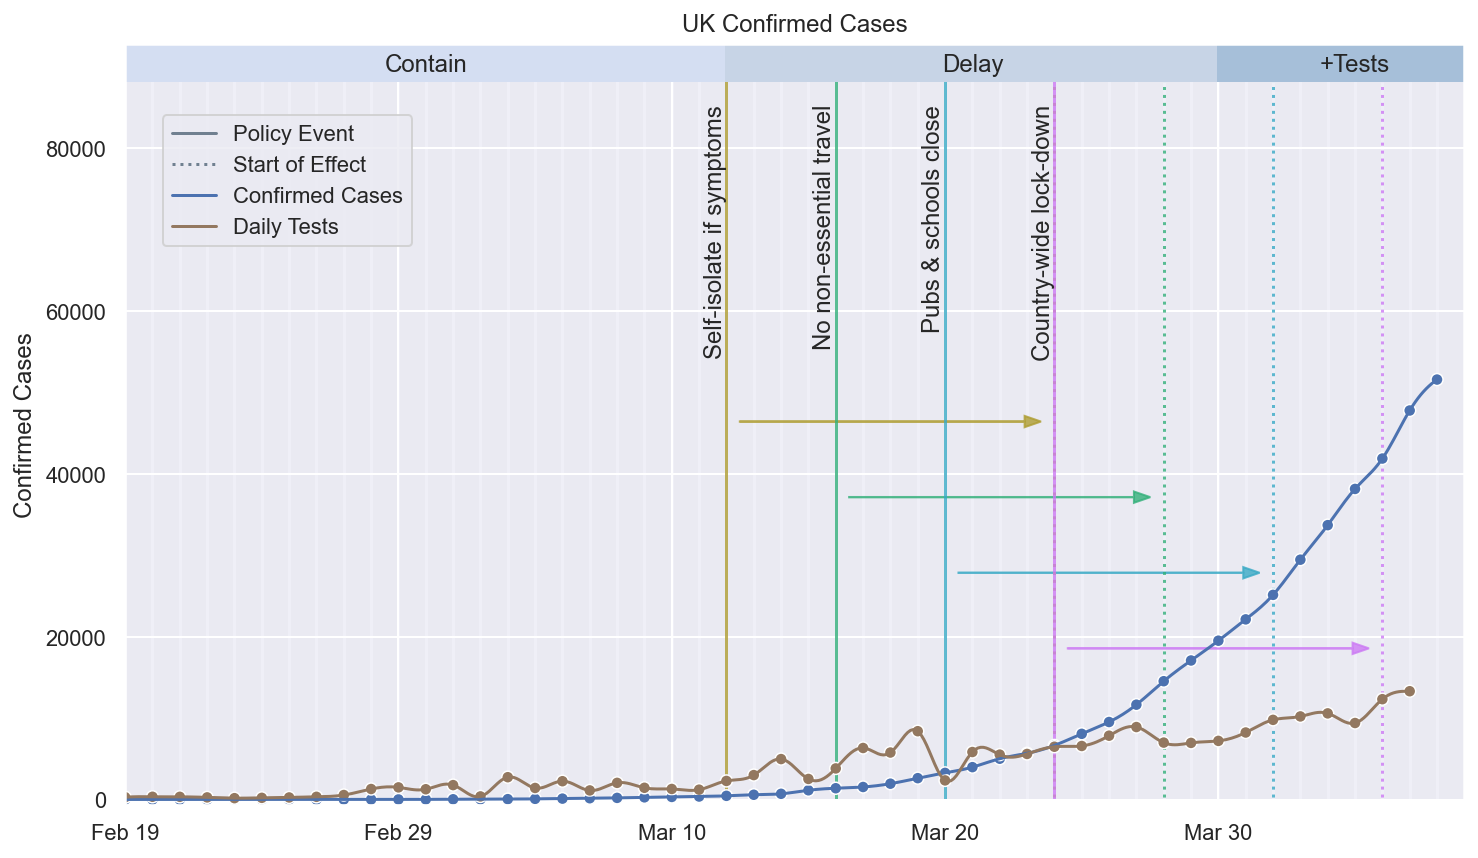

In [8]:

uk_metadata = {
    "country": "United Kingdom",
    "country_code": "UK",
    "events": [
        #{"type": "case", "label": "10th case", "date": date(2020, 2, 24), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        #{"type": "case", "label": "1st death", "date": date(2020, 3, 5), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        {"type": "policy", "label": "Self-isolate if symptoms", "date": date(2020, 3, 12), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        {"type": "policy", "label": "No non-essential travel", "date": date(2020, 3, 16), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        {"type": "policy", "label": "Pubs & schools close", "date": date(2020, 3, 20), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        {"type": "policy", "label": "Country-wide lock-down", "date": date(2020, 3, 24), "source": "https://www.theguardian.com/world/2020/mar/24/uk-coronavirus-lockdown-rules-what-you-can-and-cannot-do"}
    ],
    "phases": [
        {"type": "contain", "from": date(2020, 1, 1), "to": date(2020, 3, 12), "source": "https://www.theguardian.com/world/2020/mar/12/uk-moves-to-delay-phase-of-coronavirus-plan" },
        {"type": "delay", "from": date(2020, 3, 12), "to": date(2020, 3, 30), "source": "https://www.theguardian.com/world/2020/mar/12/uk-moves-to-delay-phase-of-coronavirus-plan" },
        {"type": "+Tests", "from": date(2020, 3, 30), "to": date(2020, 12, 31), "source": "https://www.gov.uk/government/news/testing-for-coronavirus-covid-19-will-increase-to-25-000-a-day"}
    ]
}

ax0 = plt.gca()
plot_timeline("Confirmed Cases", data.loc[uk_metadata['country']]['total_cases'], uk_metadata, date(2020, 2, 19), ax0, event_delay = 12, total_tests_df = total_tests.loc['United Kingdom']['total_tests'])


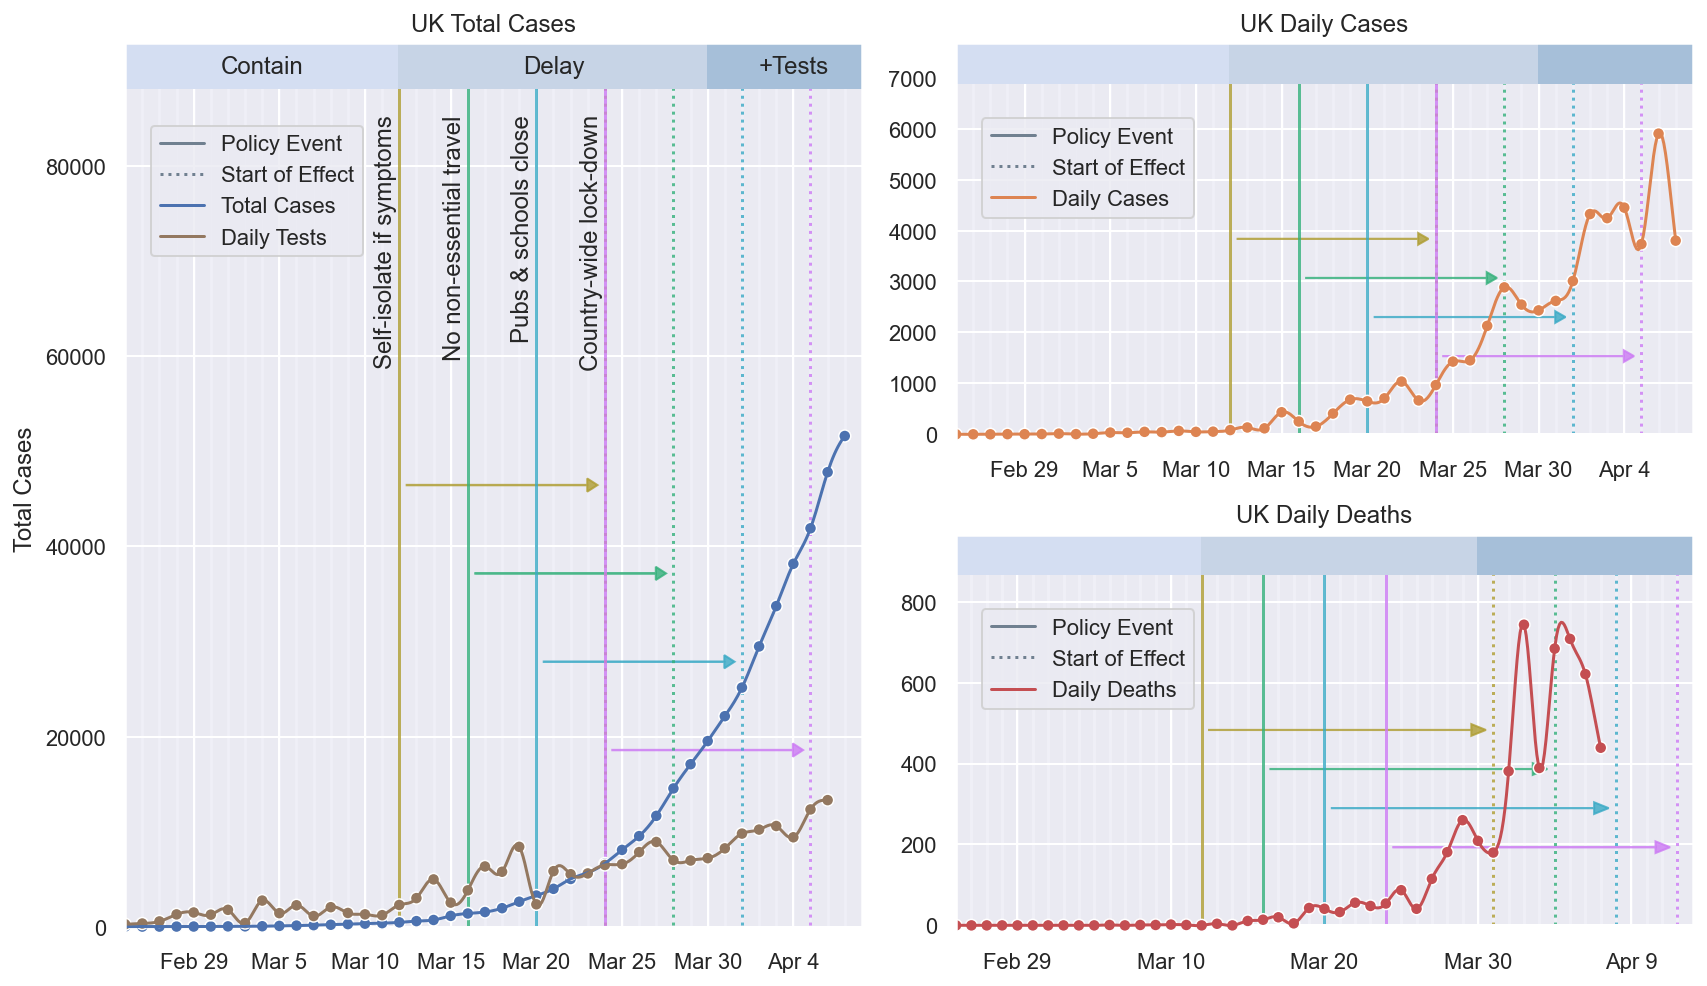

In [9]:
def plot_country(metadata, start_date, show_tests=False):
    total_tests_df = total_tests.loc[metadata['country']] if show_tests and metadata['country'] in total_tests.index.levels[0] else None
    palette = sns.color_palette()
    ax3 = plt.subplot(121)
    country_data = data.loc[metadata['country']]
    daily_case_inc = country_data['new_cases']
    #plot_timeline("Total Confirmed Cases", data.loc['United Kingdom']['total_deaths'], metadata, start_date, ax3, x_scale=0.5, line_color=palette[3])
    plot_timeline("Total Cases", country_data['total_cases'], metadata, start_date, ax3, x_scale=0.5, line_color=palette[0], event_delay=12, total_tests_df = total_tests_df)
    ax1 = plt.subplot(222)
    #plot_timeline("Daily Increase/Decrese in Cases (3-day rolling avg)", country_data_diff['new_cases'].dropna(), metadata, start_date, ax1, allow_minus=True, show_text=False, y_scale=0.5, line_color=palette[1], event_delay=12)
    plot_timeline("Daily Cases", country_data['new_cases'], metadata, start_date, ax1, allow_minus=False, show_text=False, y_scale=0.5, line_color=palette[1], event_delay=12)
    ax2 = plt.subplot(224)
    plot_timeline("Daily Deaths", country_data['new_deaths'], metadata, start_date, ax2, show_text=False, y_scale=0.5, line_color=palette[3], event_delay=19)
    plt.tight_layout()
    
plot_country(uk_metadata, date(2020, 2, 25), show_tests=True)
plt.savefig("plots/uk.png", dpi=300)

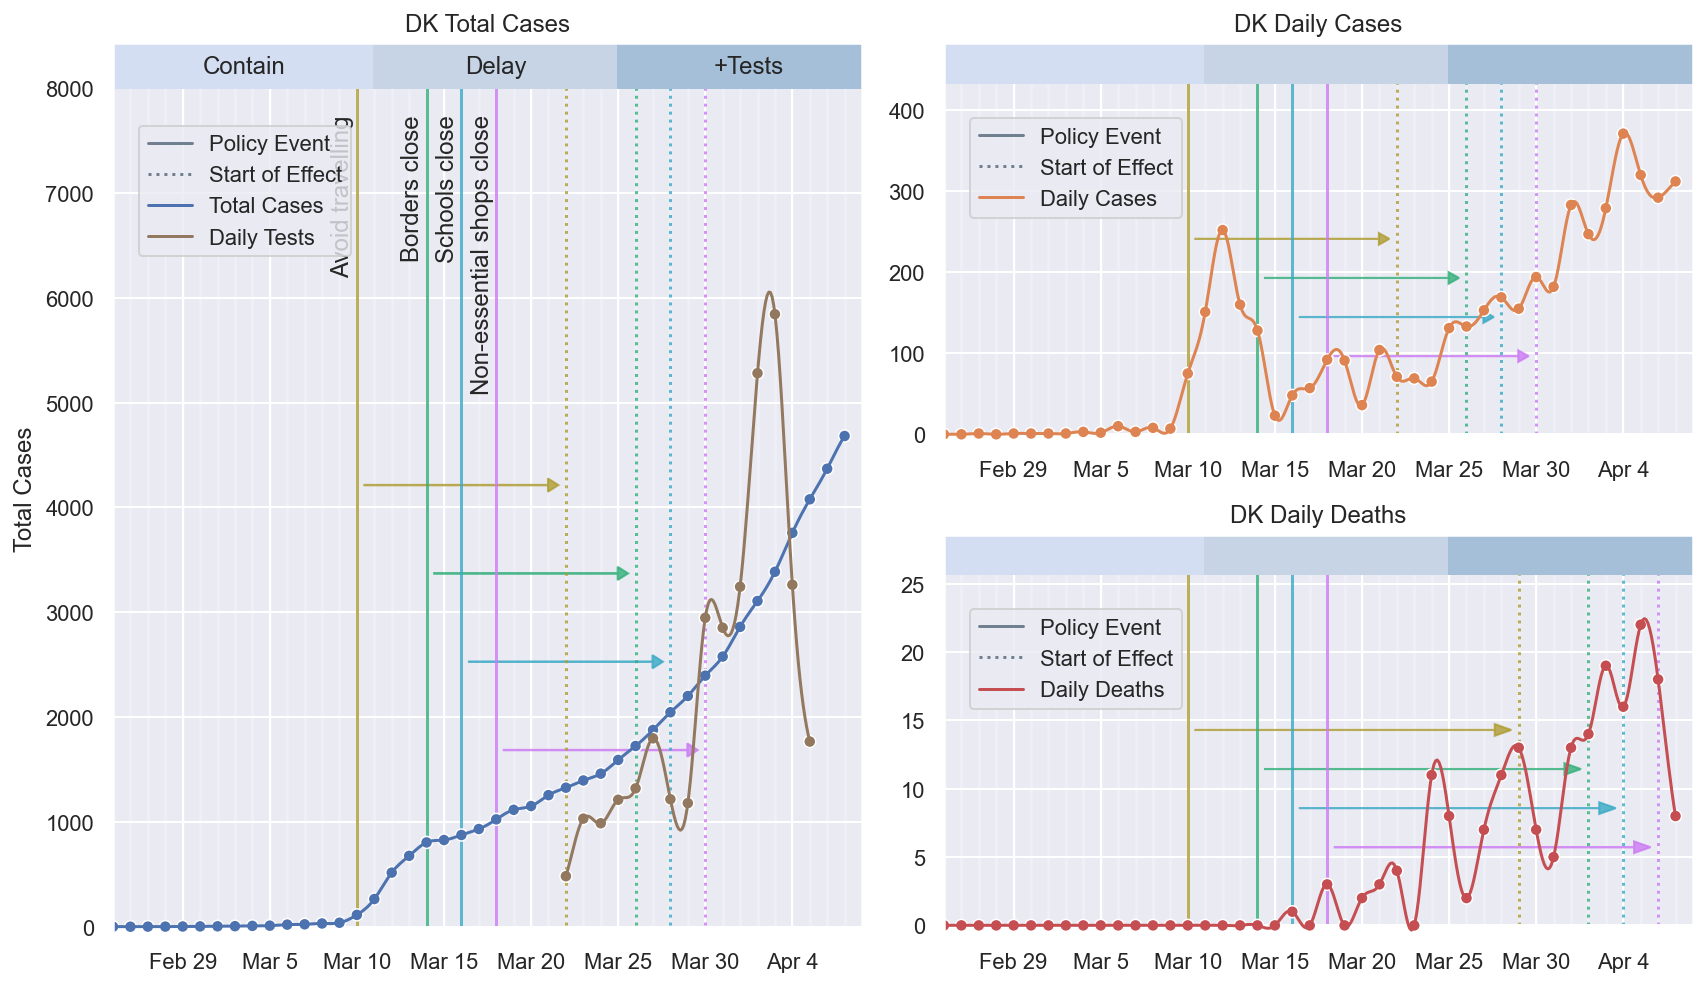

In [10]:
dk_metadata = {
    "country": "Denmark",
    "country_code": "DK",
    "events": [
        {"type": "policy", "label": "Avoid travelling", "date": date(2020, 3, 10), "source": "https://www.dr.dk/nyheder/indland/undgaa-visse-rejser-og-drop-tog-i-myldretiden-her-er-myndighedernes-corona"},
        {"type": "policy", "label": "Borders close", "date": date(2020, 3, 14), "source": "https://politi.dk/coronavirus-i-danmark/hvis-du-skal-rejse-ind-i-eller-via-danmark"},
        {"type": "policy", "label": "Schools close", "date": date(2020, 3, 16), "source": "https://politi.dk/coronavirus-i-danmark/hvis-du-har-boern-i-skole-eller-dagstilbud"},
        {"type": "policy", "label": "Non-essential shops close", "date": date(2020, 3, 18), "source": "https://politi.dk/en/coronavirus-in-denmark/17-march-2020-new-initiatives-to-prevent-the-spread-of-coronavirus-covid19"}
    ],
    "phases": [
        {"type": "contain", "from": date(2020, 1, 1), "to": date(2020, 3, 11), "source": "https://jyllands-posten.dk/indland/ECE12003712/sundhedsstyrelsen-skifter-strategi-ikke-alle-coronasymptomer-skal-testes/" },
        {"type": "delay", "from": date(2020, 3, 11), "to": date(2020, 3, 25), "source": "https://jyllands-posten.dk/indland/ECE12003712/sundhedsstyrelsen-skifter-strategi-ikke-alle-coronasymptomer-skal-testes/" },
        {"type": "+Tests", "from": date(2020, 3, 25), "to": date(2020, 12, 31), "source": "https://www.dr.dk/nyheder/indland/sundhedsstyrelsen-vil-teste-5000-danskere-corona-om-dagen" }
    ]
}
plot_country(dk_metadata, date(2020, 2, 25), show_tests=True)
plt.savefig("plots/dk.png", dpi=300)

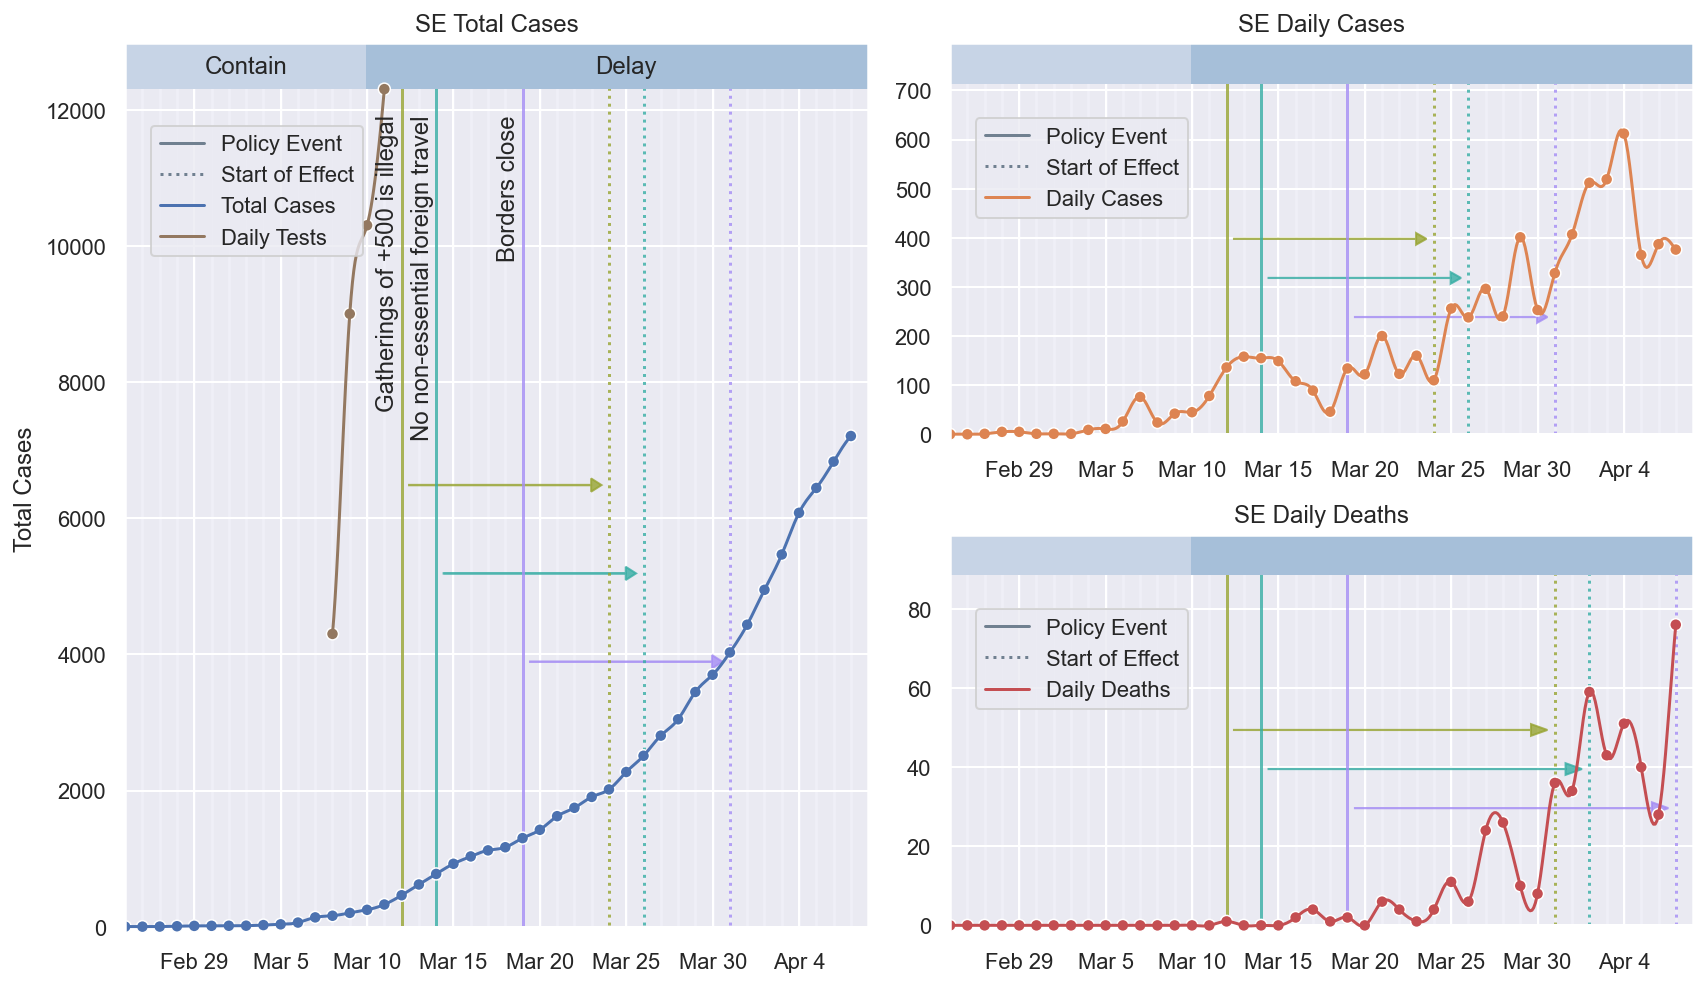

In [11]:
se_metadata = {
    "country": "Sweden",
    "country_code": "SE",
    "events": [
        {"type": "policy", "label": "Gatherings of +500 is illegal", "date": date(2020, 3, 12), "source": "https://www.government.se/articles/2020/03/ordinance-on-a-prohibition-against-holding-public-gatherings-and-events/"},        
        {"type": "policy", "label": "No non-essential foreign travel", "date": date(2020, 3, 14), "source": "https://www.government.se/press-releases/2020/03/ministry-for-foreign-affairs-advises-against-non-essential-travel-to-all-countries/"},
        {"type": "policy", "label": "Borders close", "date": date(2020, 3, 19), "source": "https://www.government.se/press-releases/2020/03/temporary-ban-on-travel-to-sweden-due-to-covid-19/"}
    ],
    "phases": [
        {"type": "contain", "from": date(2020, 1, 1), "to": date(2020, 3, 10), "source": "http://www.chinadaily.com.cn/a/202003/13/WS5e6afc8fa31012821727ee10.html" },
        {"type": "delay", "from": date(2020, 3, 10), "to": date(2020, 12, 31), "source": "http://www.chinadaily.com.cn/a/202003/13/WS5e6afc8fa31012821727ee10.html" }
    ]
}
plot_country(se_metadata, date(2020, 2, 25), show_tests=True)
plt.savefig("plots/se.png", dpi=300)

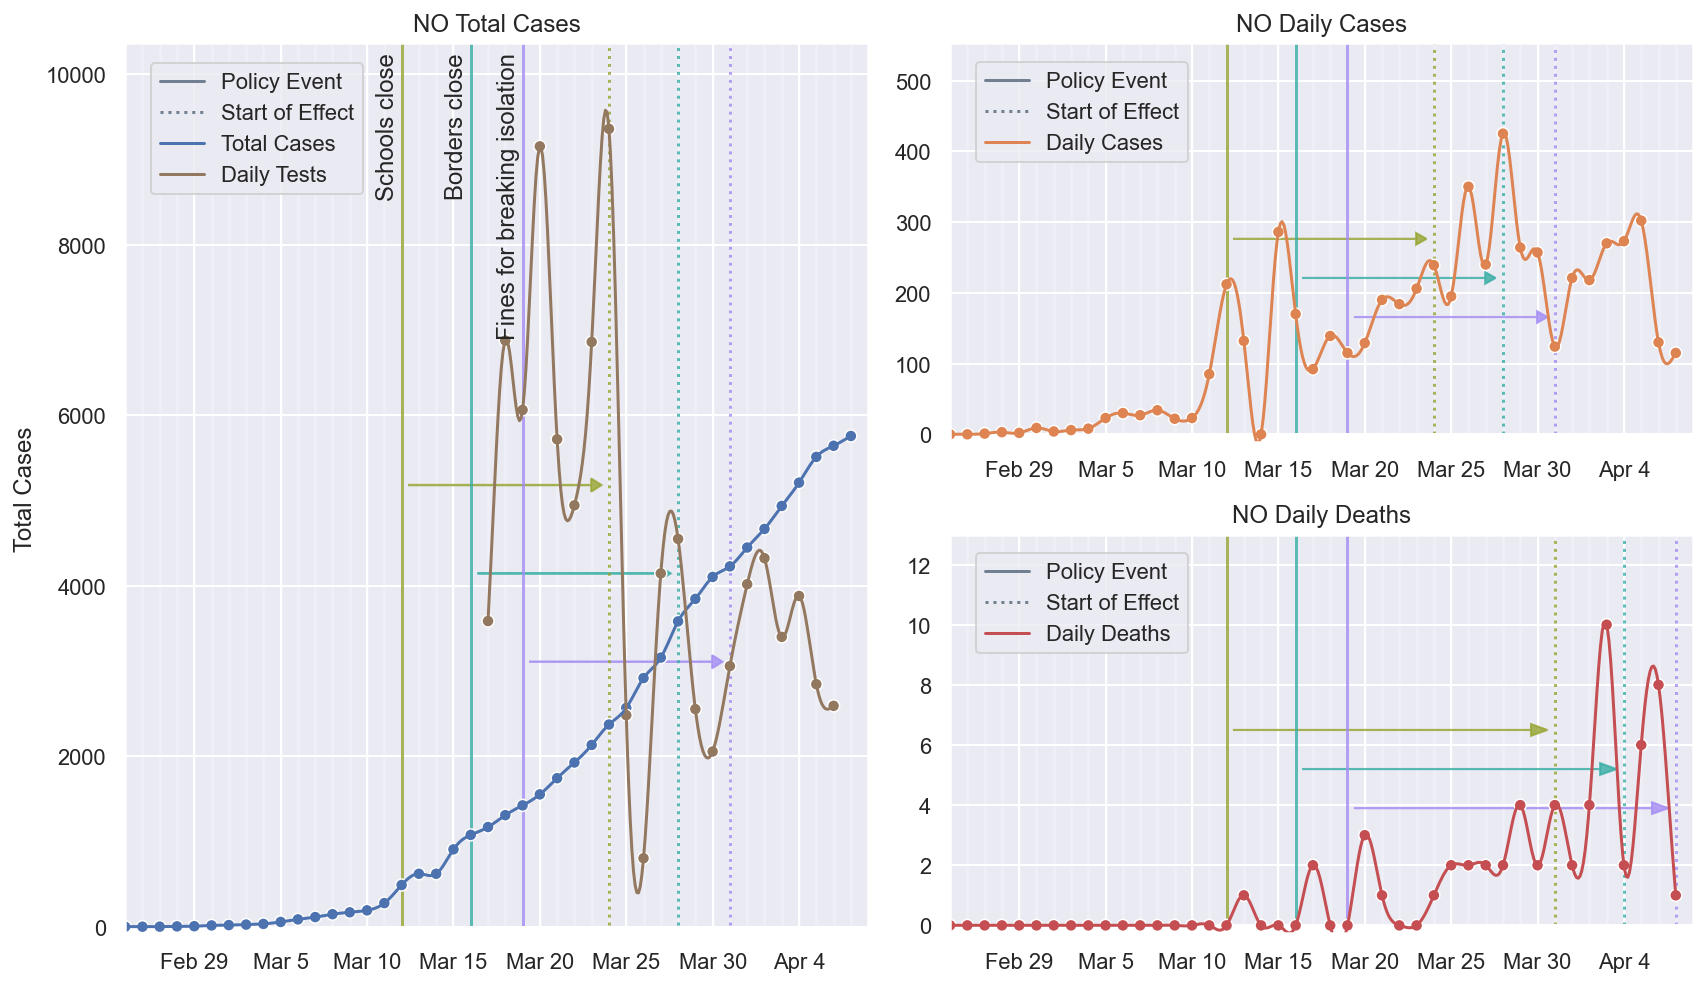

In [12]:
no_metadata = {
    "country": "Norway",
    "country_code": "NO",
    "events": [
        {"type": "policy", "label": "Schools close", "date": date(2020, 3, 12), "source": "https://www.nrk.no/norge/alle-utdanningsinstitusjoner-stenges-_-flere-arrangementer-og-virksomheter-far-forbud-1.14940952"},        
        {"type": "policy", "label": "Borders close", "date": date(2020, 3, 16), "source": "https://avinor.no/en/information-in-connection-with-the-coronavirus-covid-19/"},
        {"type": "policy", "label": "Fines for breaking isolation", "date": date(2020, 3, 19), "source": "https://www.forbes.com/sites/davidnikel/2020/03/17/norway-hands-out-2000-fines-or-jail-for-ignoring-coronavirus-quarantine/"}
    ],
    "phases": []
}
plot_country(no_metadata, date(2020, 2, 25), show_tests=True)
plt.savefig("plots/no.png", dpi=300)

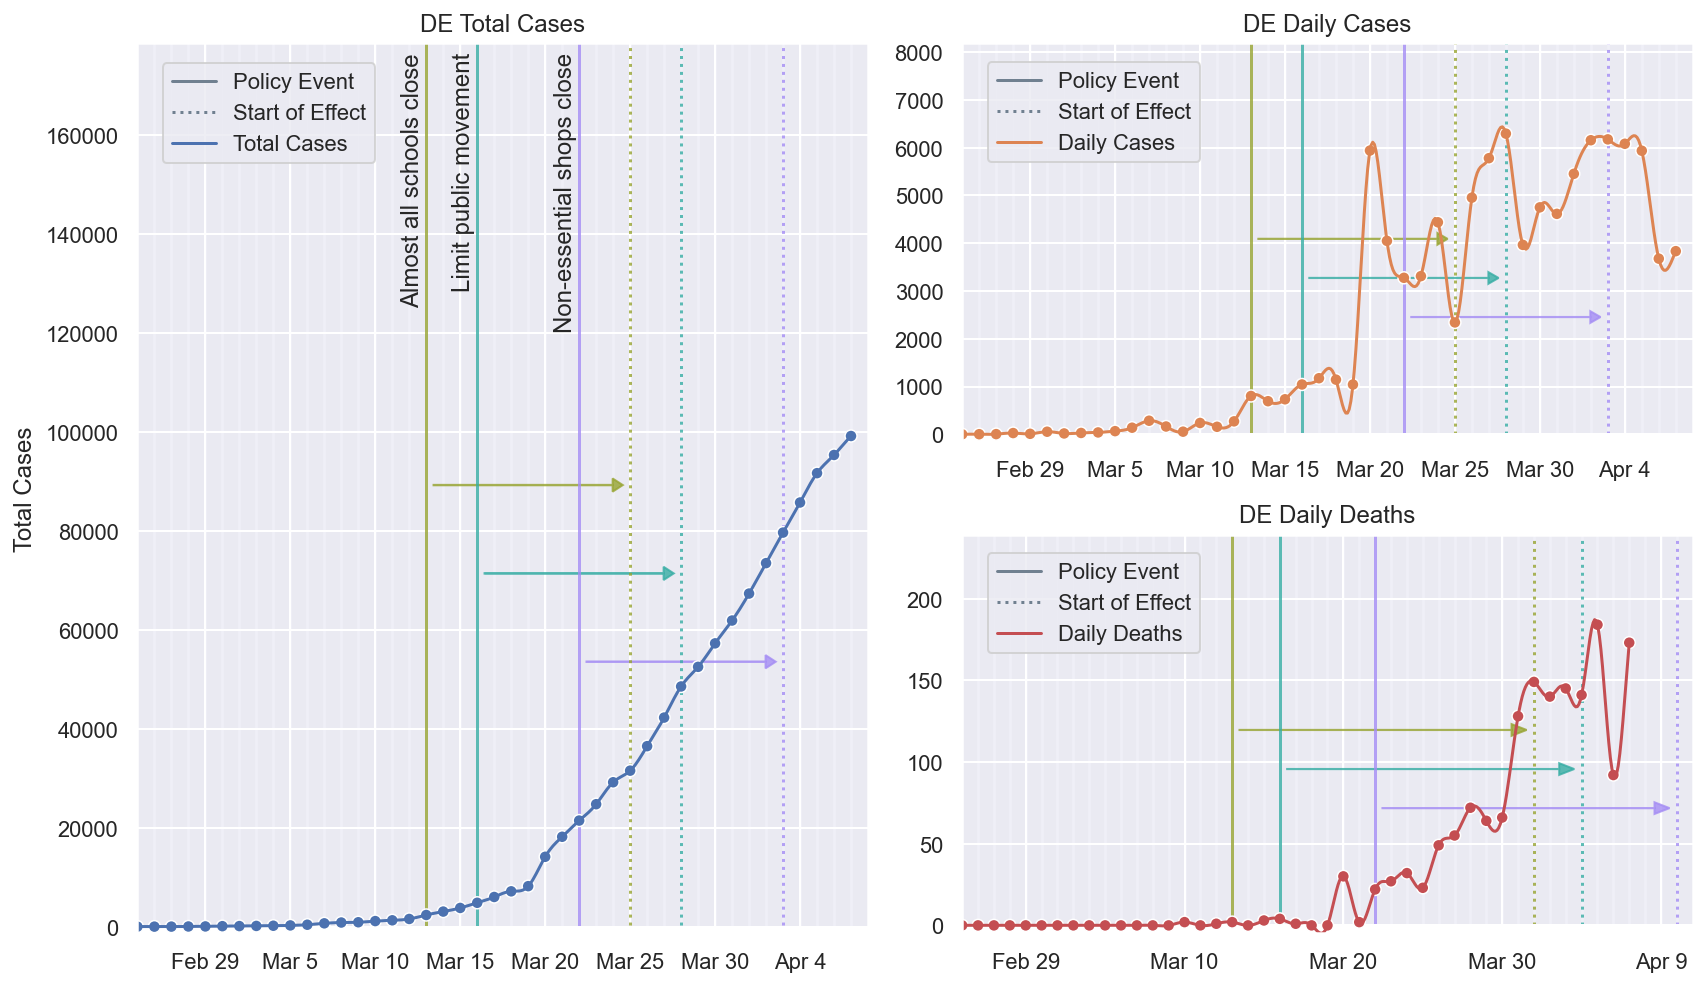

In [13]:
de_metadata = {
    "country": "Germany",
    "country_code": "DE",
    "events": [
        {"type": "policy", "label": "Almost all schools close", "date": date(2020, 3, 13), "source": "https://www.zeit.de/news/2020-03/13/bayern-schliesst-alle-schulen-wegen-coronavirus-krise"},
        {"type": "policy", "label": "Limit public movement", "date": date(2020, 3, 16), "source": "https://www.handelsblatt.com/politik/deutschland/coronakrise-deutschland-im-shutdown-modus-die-alternativlos-kanzlerin-kehrt-zurueck/25650658.html?ticket=ST-215111-cThaOcfGzEUBD4oXHhdJ-ap1"},        
        {"type": "policy", "label": "Non-essential shops close", "date": date(2020, 3, 22), "source": "https://www.politico.eu/article/merkel-bans-meetings-of-more-than-2-people-to-slow-coronavirus/"}
    ],
    "phases": []
}
plot_country(de_metadata, date(2020, 2, 25), show_tests=False)
plt.savefig("plots/de.png", dpi=300)

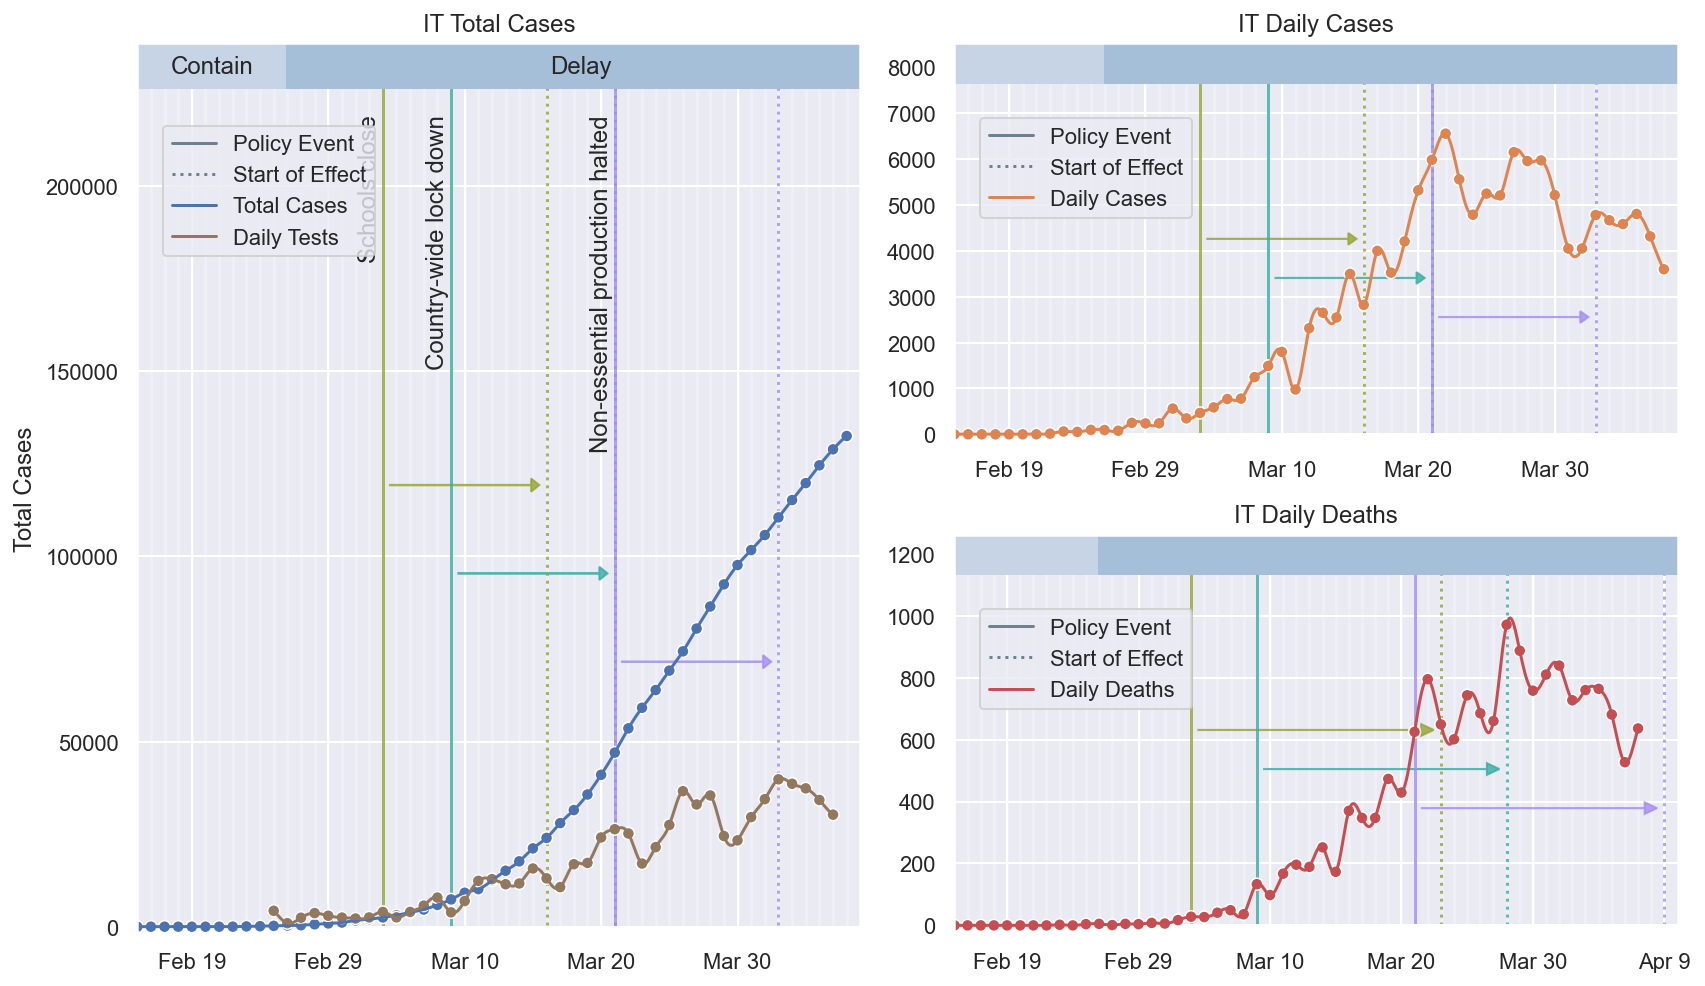

In [14]:
it_metadata = {
    "country": "Italy",
    "country_code": "IT",
    "events": [
        {"type": "policy", "label": "Schools close", "date": date(2020, 3, 4), "source": "https://www.corriere.it/scuola/20_marzo_04/coronavirus-scuole-chiuse-tutta-italia-decisione-governo-entro-stasera-e7ba0614-5e12-11ea-8e26-25d9a5210d01.shtml"},        
        {"type": "policy", "label": "Country-wide lock down", "date": date(2020, 3, 9), "source": "https://www.bbc.co.uk/news/world-europe-51810673"},
        {"type": "policy", "label": "Non-essential production halted", "date": date(2020, 3, 21), "source": "https://www.theguardian.com/world/2020/mar/22/italian-pm-warns-of-worst-crisis-since-ww2-as-coronavirus-deaths-leap-by-almost-800"}
    ],
    "phases": [
        {"type": "contain", "from": date(2020, 1, 1), "to": date(2020, 2, 26), "source": "https://tg24.sky.it/cronaca/2020/02/26/coronavirus-tamponi-solo-su-sintomatici.html" },
        {"type": "delay", "from": date(2020, 2, 26), "to": date(2020, 12, 31), "source": "https://tg24.sky.it/cronaca/2020/02/26/coronavirus-tamponi-solo-su-sintomatici.html" }
    ]
    
}
plot_country(it_metadata, date(2020, 2, 15), show_tests=True)
plt.savefig("plots/it.png", dpi=300)

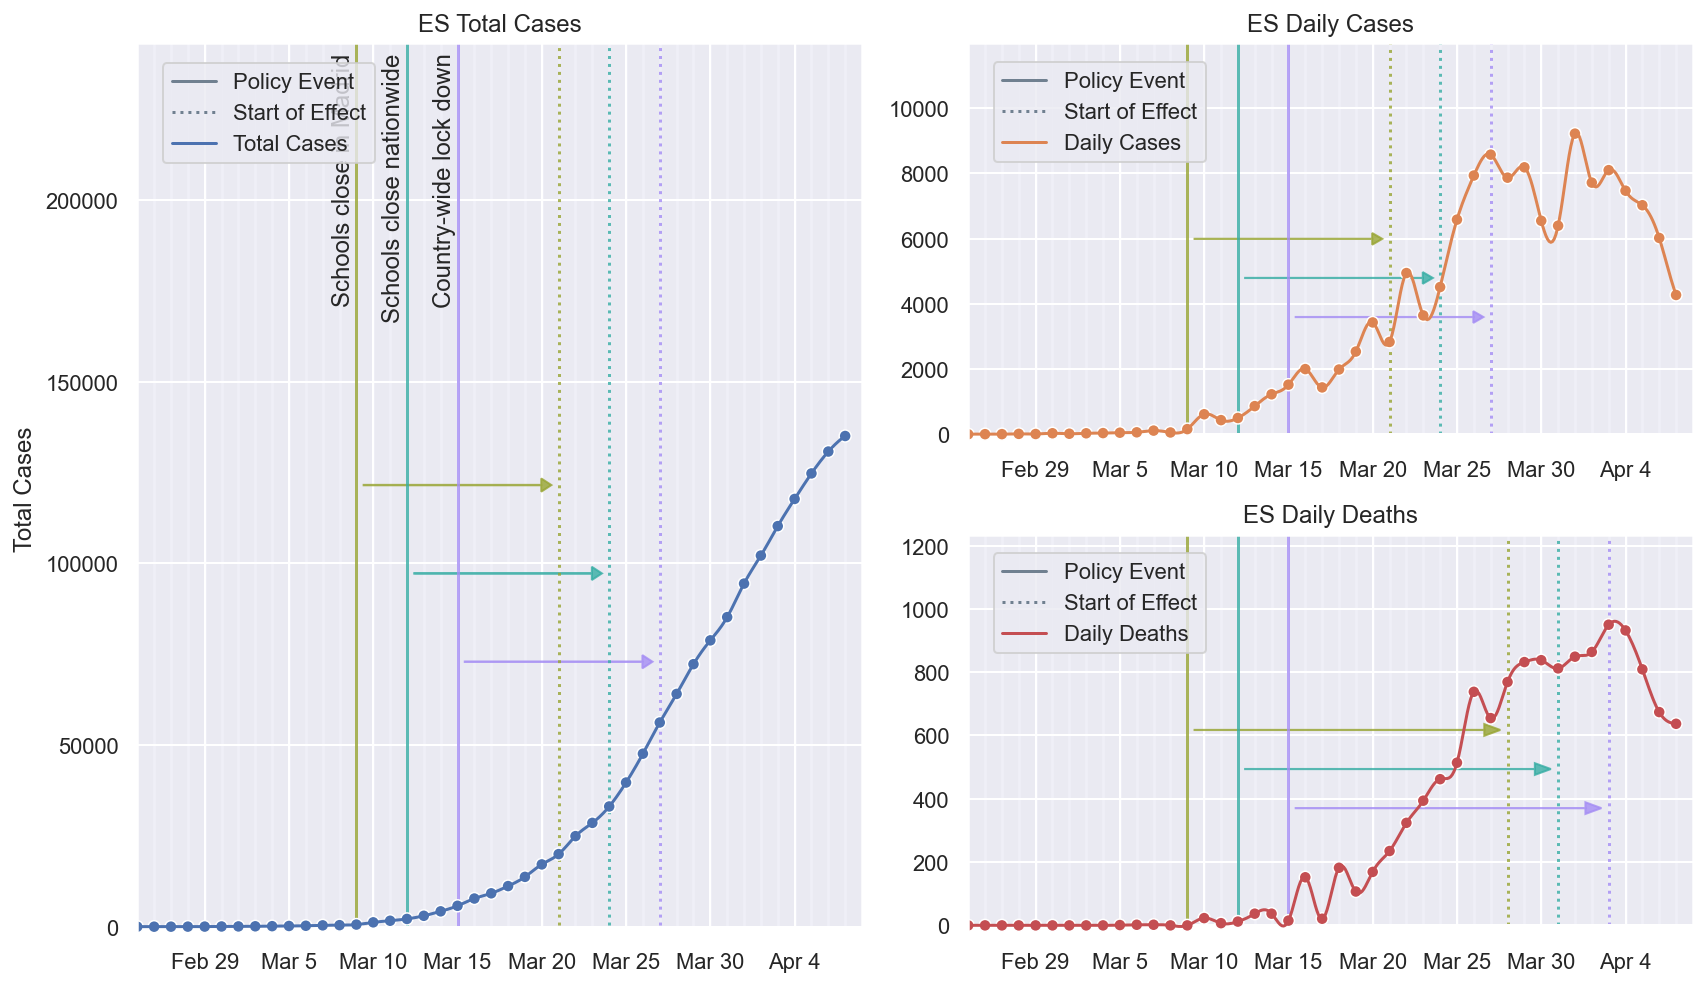

In [15]:
es_metadata = {
    "country": "Spain",
    "country_code": "ES",
    "events": [
        {"type": "policy", "label": "Schools close in Madrid", "date": date(2020, 3, 9), "source": "https://www.comunidad.madrid/noticias/2020/03/09/comunidad-madrid-aprueba-medidas-extraordinarias-coronavirus"},
        {"type": "policy", "label": "Schools close nationwide", "date": date(2020, 3, 12), "source": "https://elpais.com/sociedad/2020-03-12/suspendidas-las-clases-en-todos-los-centros-educativos-de-euskadi.html"},
        {"type": "policy", "label": "Country-wide lock down", "date": date(2020, 3, 15), "source": "https://www.corriere.it/scuola/20_marzo_04/coronavirus-scuole-chiuse-tutta-italia-decisione-governo-entro-stasera-e7ba0614-5e12-11ea-8e26-25d9a5210d01.shtml"}
    ],
    "phases": []
    
}
plot_country(es_metadata, date(2020, 2, 25), show_tests=True)
plt.savefig("plots/es.png", dpi=300)

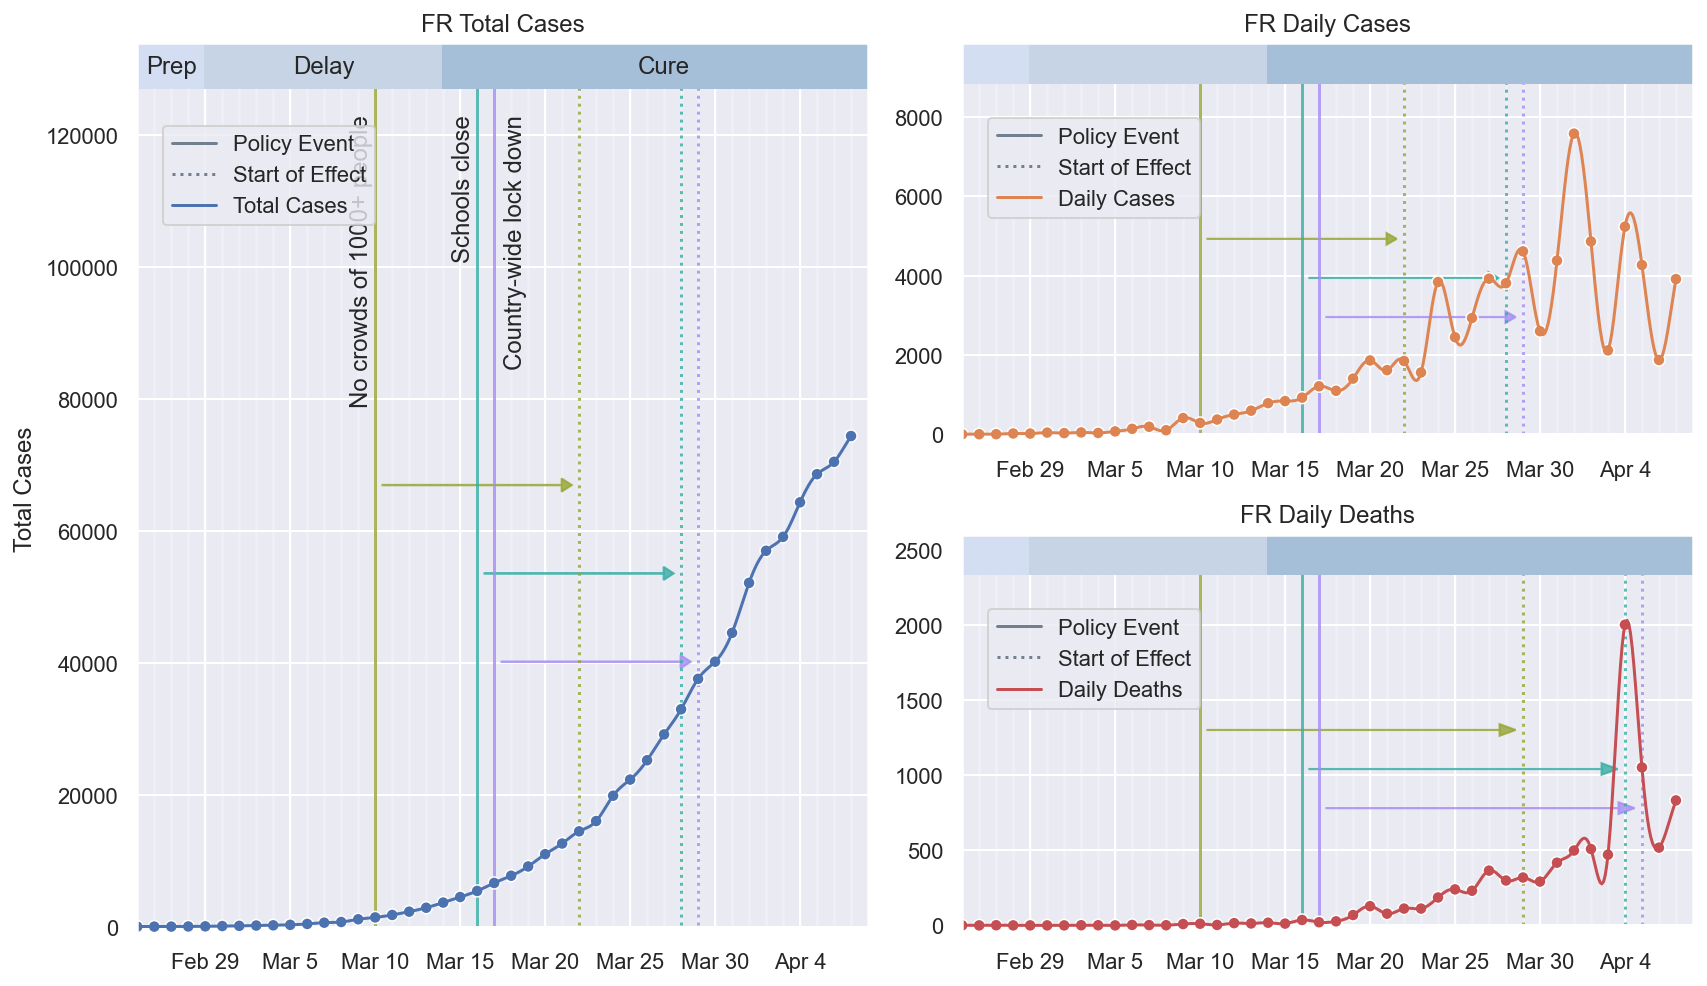

In [16]:
fr_metadata = {
    "country": "France",
    "country_code": "FR",
    "events": [
        {"type": "policy", "label": "No crowds of 1000+ people", "date": date(2020, 3, 10), "source": "https://www.legifrance.gouv.fr/WAspad/UnTexteDeJorf?numjo=SSAZ2007069A"},
        {"type": "policy", "label": "Schools close", "date": date(2020, 3, 16), "source": "https://www.bbc.co.uk/news/world-europe-51892477"},
        {"type": "policy", "position": "under", "label": "Country-wide lock down", "date": date(2020, 3, 17), "source": "https://www.legifrance.gouv.fr/affichTexte.do?cidTexte=JORFTEXT000041728476&dateTexte=&categorieLien=id"}
    ],
    "phases": [
        {"type": "prep", "from": date(2020, 2, 1), "to": date(2020, 2, 29), "source": "https://fr.wikipedia.org/wiki/Pand%C3%A9mie_de_maladie_%C3%A0_coronavirus_de_2020_en_France" },
        {"type": "delay", "from": date(2020, 2, 29), "to": date(2020, 3, 14), "source": "https://fr.wikipedia.org/wiki/Pand%C3%A9mie_de_maladie_%C3%A0_coronavirus_de_2020_en_France" },
        {"type": "cure", "from": date(2020, 3, 14), "to": date(2020, 12, 14), "source": "https://fr.wikipedia.org/wiki/Pand%C3%A9mie_de_maladie_%C3%A0_coronavirus_de_2020_en_France" }
    ]
    
}
plot_country(fr_metadata, date(2020, 2, 25), show_tests=False)
plt.savefig("plots/fr.png", dpi=300)

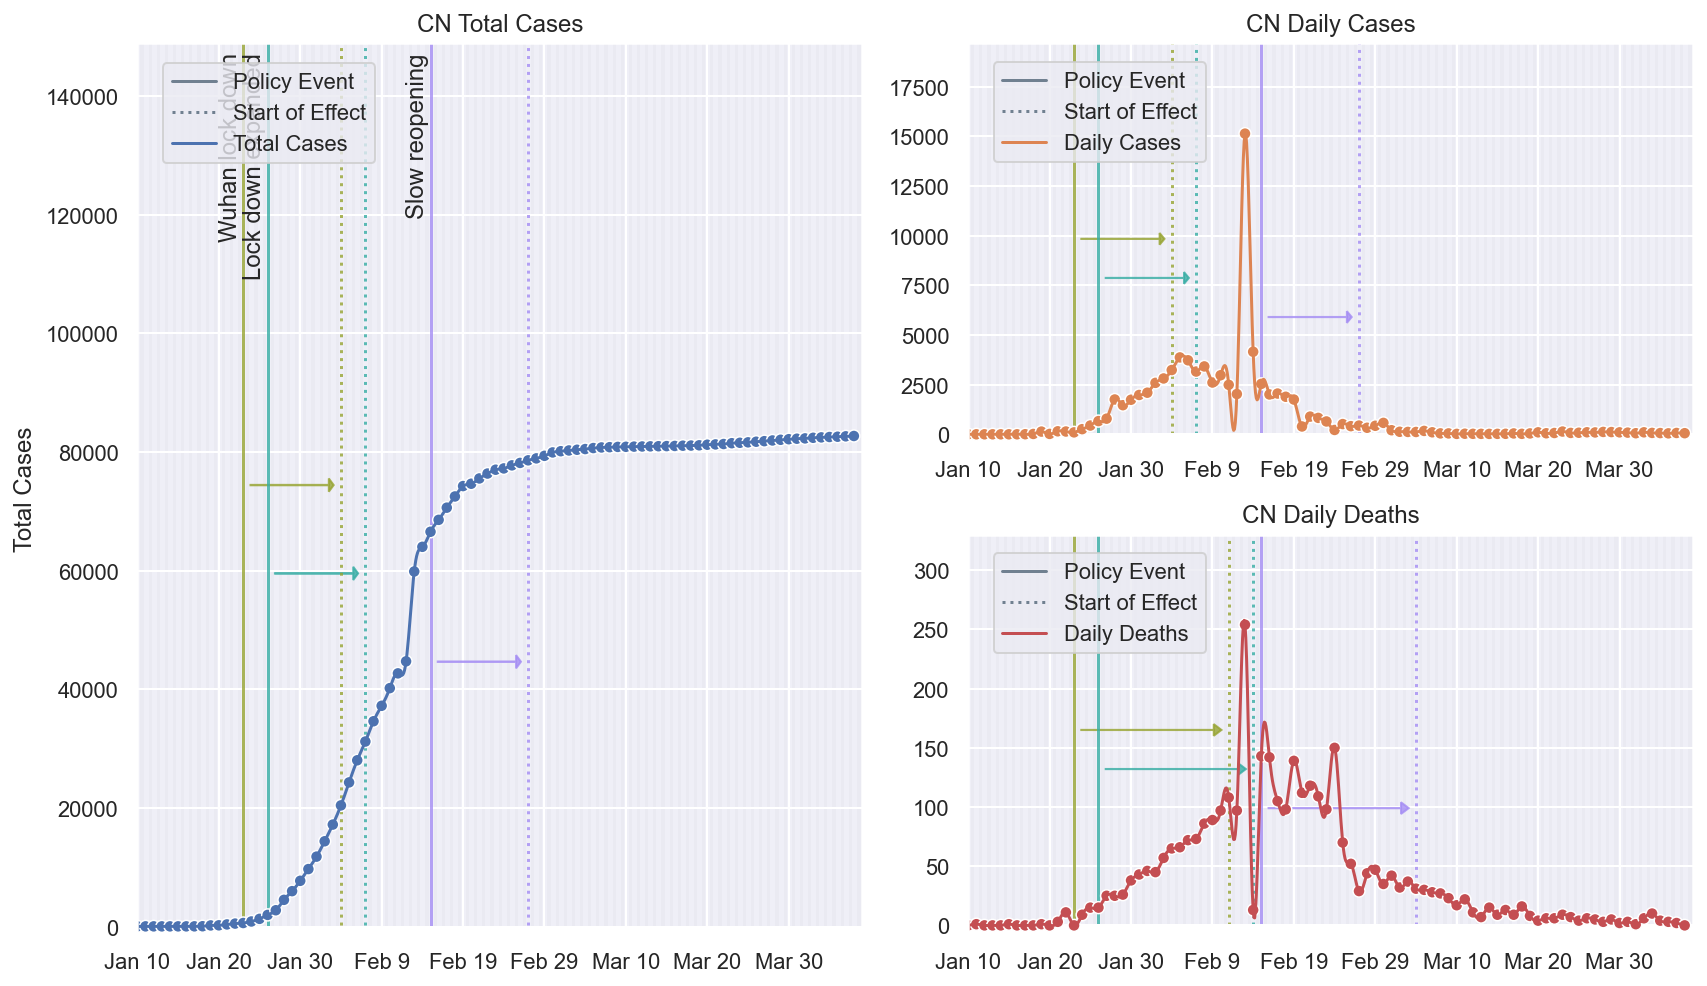

In [17]:
cn_metadata = {
    "country": "China",
    "country_code": "CN",
    "events": [
        {"type": "policy", "label": "Wuhan lock down", "date": date(2020, 1, 23), "source": ""},
        {"type": "policy", "label": "Lock down expanded", "date": date(2020, 1, 26), "source": ""},
        {"type": "policy", "label": "Slow reopening", "date": date(2020, 2, 15), "source": ""}
    ],
    "phases": []
    
}
plot_country(cn_metadata, date(2020, 1, 10))
plt.savefig("plots/cn.png", dpi=300)

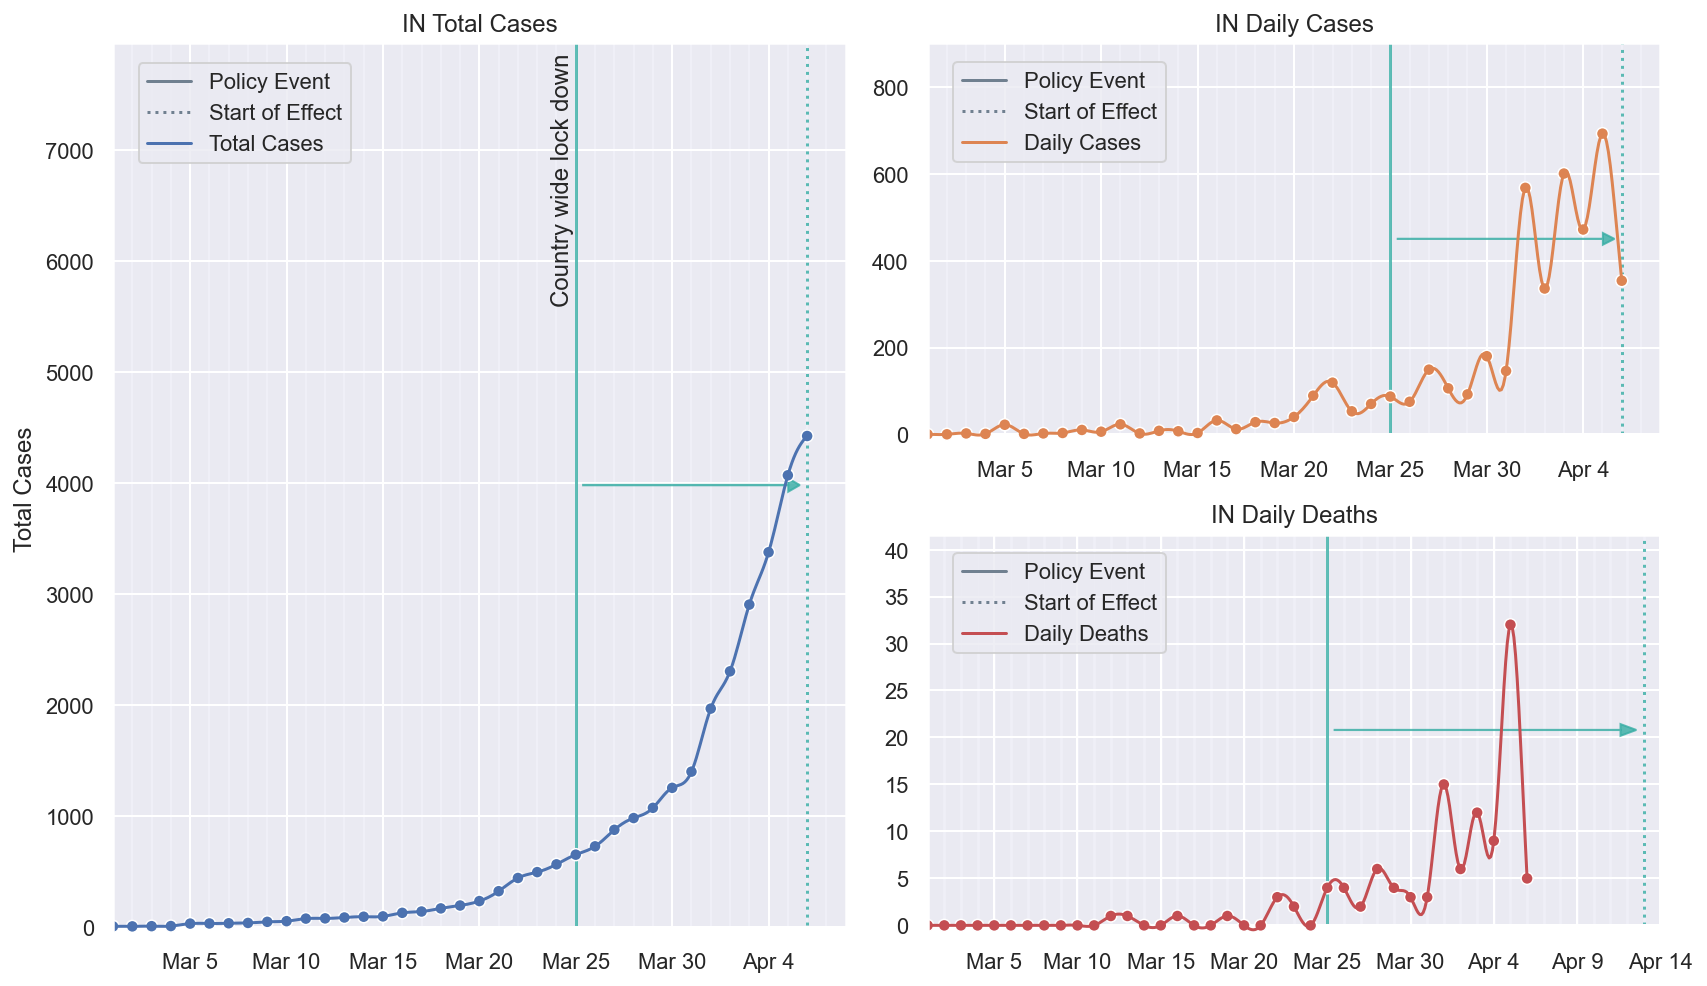

In [18]:
in_metadata = {
    "country": "India",
    "country_code": "IN",
    "events": [
        {"type": "policy", "label": "Country wide lock down", "date": date(2020, 3, 25), "source": "https://www.theguardian.com/world/2020/mar/24/indias-13bn-population-locked-down-to-beat-coronavirus"}
    ],
    "phases": []
    
}
plot_country(in_metadata, date(2020, 3, 1), show_tests=False)
plt.savefig("plots/in.png", dpi=300)

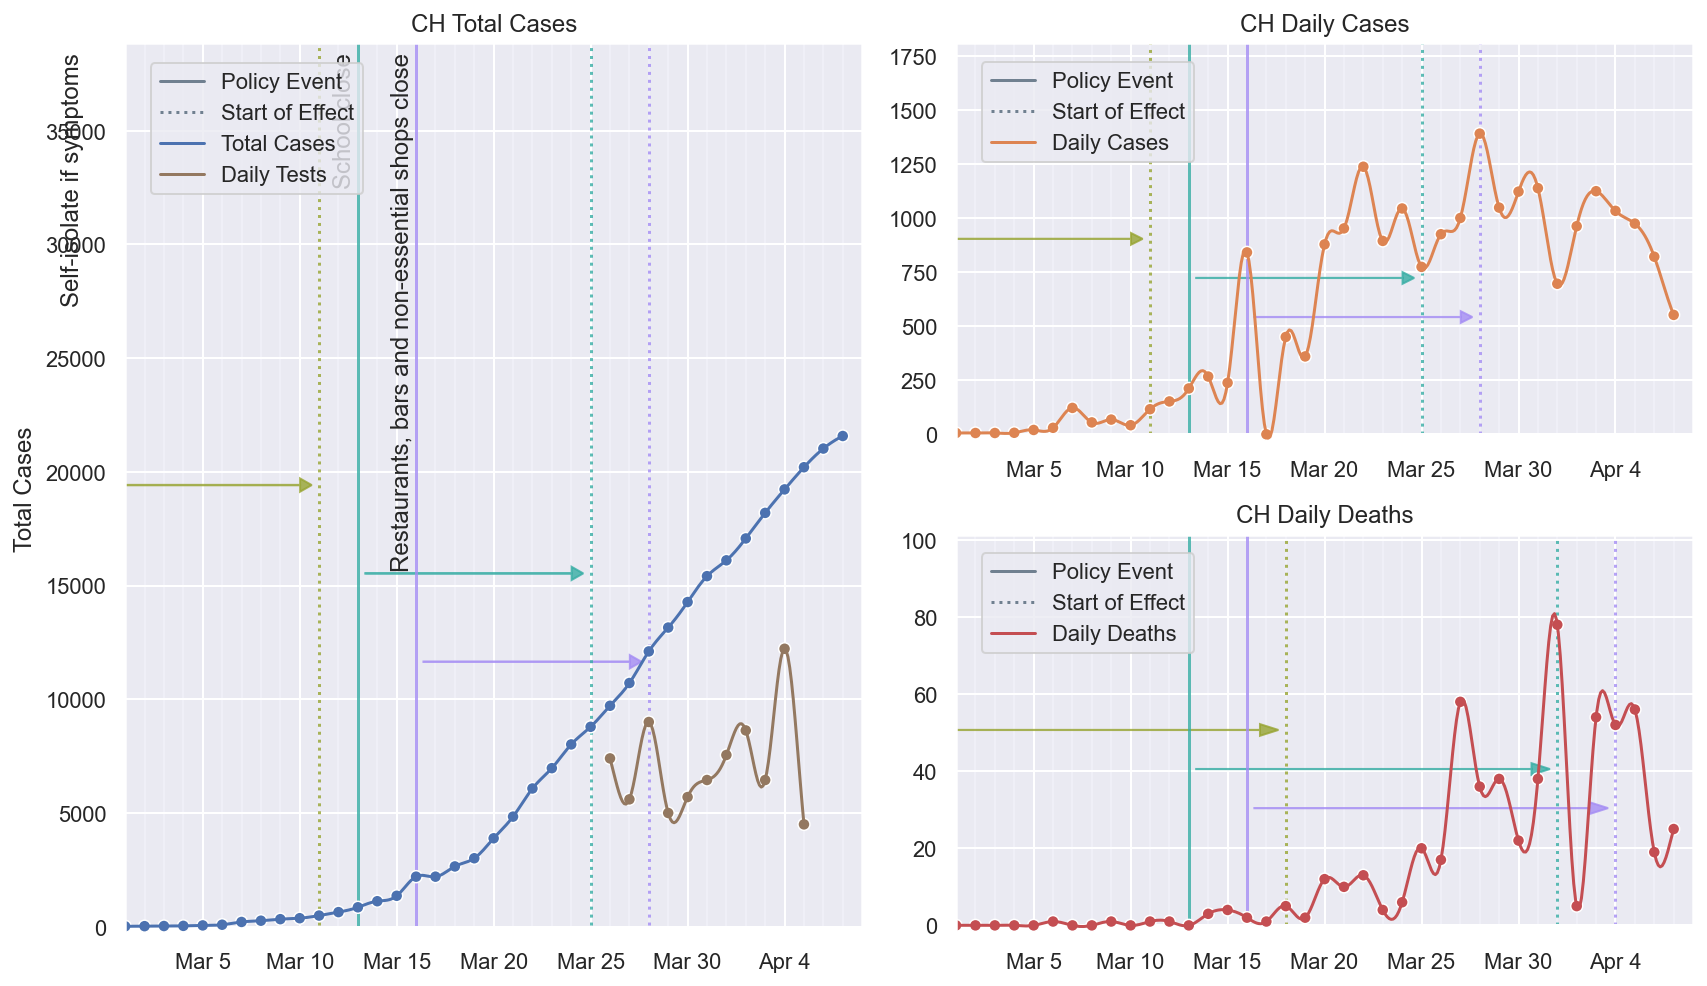

In [19]:

ch_metadata = {
    "country": "Switzerland",
    "country_code": "CH",
    "events": [
        
        {"type": "policy", "label": "Self-isolate if symptoms", "date": date(2020, 2, 28), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Switzerland"},
                {"type": "policy", "label": "School close", "date": date(2020, 3, 13), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Switzerland"},
        {"type": "policy", "label": "Restaurants, bars and non-essential shops close", "date": date(2020, 3, 16), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Switzerland"},
    ],
    "phases": [
    ]
}

plot_country(ch_metadata, date(2020, 3, 1), show_tests=True)
plt.savefig("plots/ch.png", dpi=300)